# Import Functions

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob

%matplotlib inline

# Step 1: Calibrate Camera

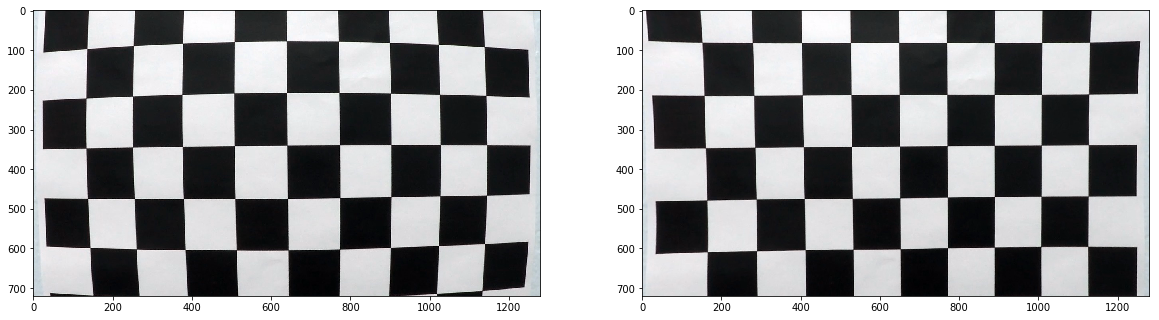

In [2]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('camera_cal/*.jpg')
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (nx,ny), corners2,ret)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

example = 'camera_cal/calibration1.jpg'
img = cv2.imread(example)
h, w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 0, (w,h))
undistorted = cv2.undistort(img, mtx, dist, None, newcameramtx)
fig = plt.figure(figsize = (20, 20))
fig.add_subplot(1, 2, 1)
plt.imshow(img)
fig.add_subplot(1, 2, 2)
plt.imshow(undistorted)

# Step 2: Pipeline Helper Functions

In [3]:
def undistort(img):
    h, w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 0, (w,h))
    return cv2.undistort(img, mtx, dist, None, newcameramtx)

def sobelx(img, ksize = 5, thresh = 20):
    sobelx = cv2.Sobel(img,cv2.CV_64F, 1, 0, ksize = ksize)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    ret, thresh = cv2.threshold(scaled_sobelx, thresh, 255, cv2.THRESH_BINARY)
    return thresh

def thresh_white(img, thresh = 208):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, thresh, 255, cv2.THRESH_BINARY)
    return thresh

def thresh_hlS(img, thresh = 128):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    lower_S = np.array([0, 0, 128])
    upper_S = np.array([72 ,255, 255])
    return cv2.inRange(hls, lower_S, upper_S)

def thresh_yellow(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([15,80,80])
    upper_yellow = np.array([25,255,255])
    return cv2.inRange(hsv, lower_yellow, upper_yellow)

def thresh_green(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_green = np.array([20,10,10])
    upper_green = np.array([50,160,160])
    return cv2.inRange(hsv, lower_green,upper_green)

def transform(img):
    h, w = img.shape[:2]
    dx = 200
    pts1 = np.float32([[265, 685],[620, 440],[680, 440],[1050, 685]])
    pts2 = np.float32([[dx, w], [dx, 0], [h - dx, 0], [h - dx, w]])

    M = cv2.getPerspectiveTransform(pts1, pts2)

    return cv2.warpPerspective(img, M, (h, w))

def retransform(img):
    h, w = img.shape[:2]
    dx = 200
    pts1 = np.float32([[265, 685],[620, 440],[680, 440],[1050, 685]])
    pts2 = np.float32([[dx, h], [dx, 0], [w - dx, 0], [w - dx, h]])

    M = cv2.getPerspectiveTransform(pts2, pts1)

    return cv2.warpPerspective(img, M, (h, w))

#Sliding window algorithm
def sliding_window(transformed, leftx_base, rightx_base, nwindows = 15):
    h, w = transformed.shape[:2]
    
    # Set height of windows
    window_height = np.int(h//nwindows)
    
    out_img = np.dstack((transformed, transformed, transformed))
    
    nonzero = transformed.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    #do we search right and left?
    active_left = True
    active_right = True
    #momentum
    momentum_left = 0
    momentum_right = 0
    
    
    # Step through the windows one by one
    for window in range(nwindows):
        momentum_base_left = leftx_current
        momentum_base_right = rightx_current
        leftx_current += momentum_left
        rightx_current += momentum_right
        
        for _ in range(3):
        # Identify window boundaries in x and y (and right and left)
            win_y_low = int(h - (window+1)*window_height)
            win_y_high = int(h - window*window_height)
            win_xleft_low = int(leftx_current - margin)
            win_xleft_high = int(leftx_current + margin)
            win_xright_low = int(rightx_current - margin)
            win_xright_high = int(rightx_current + margin)
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
        momentum_left = leftx_current - momentum_base_left
        momentum_right = rightx_current - momentum_base_right
        if leftx_current > rightx_current:
            break
        
        if active_left:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2)
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
        if active_right:
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2)
            right_lane_inds.append(good_right_inds)
        
        #recognize leaving the window left or right
        if leftx_current < margin // 2 and len(good_left_inds) < minpix:
            active_left = False
        if rightx_current > w - (margin // 2) and len(good_right_inds) < minpix:
            active_right = False
    
    left_fit, right_fit = None, None
    # Concatenate the arrays of indices
    if len(left_lane_inds) > 0:
        left_lane_inds = np.concatenate(left_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
    
        # Fit a second order polynomial to each if more than 2000 pixels found
        if len(lefty) > 2000:
            left_fit = np.polyfit(lefty, leftx, 2)
    
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        
    if len(right_lane_inds) > 0:
        right_lane_inds = np.concatenate(right_lane_inds)
        
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        if len(righty) > 2000:
            right_fit = np.polyfit(righty, rightx, 2)
            
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return left_fit, right_fit, out_img


def calcCurvature(ploty, fitx):
    #Step 7 Calculate curvature:
    # Define conversions in x and y from pixels space to meters
    length = np.max(ploty)
    ym_per_pix = 70/length # meters per pixel in y dimension
    xm_per_pix = 3.7/330 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(ploty*ym_per_pix, fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    
    points = 5
    curverad = 0
    for i in range(points):
        y = length - i * 20
        curverad += ((1 + (2*fit_cr[0]*y*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])

    curverad = curverad / points
    
    return curverad

#Compare found lanes with each other and previous found lanes with respect to distance from each other and curvature
#Return if the new found lanes seem to be ok
def checkSanity(ploty, left_fit, right_fit, left_fit_old = None, right_fit_old = None):
    sane = [True, True]
    if left_fit is not None: 
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        left_curve = calcCurvature(ploty, left_fitx)
    else:
        left_curve = -1
        sane[0] = False
    if right_fit is not None:
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        right_curve = calcCurvature(ploty, right_fitx)
    else:
        right_curve = -1
        sane[1] = False
    if left_fit is not None and right_fit is not None:
        distance = right_fitx[-1] - left_fitx[-1]
        curve_dist = abs(left_curve - right_curve)
        if distance < 290 or distance > 360:
            sane = [False, False]
        if curve_dist > 500 and (left_curve < 4000 or right_curve < 4000):
            sane = [False, False]
    else:
        distance = -1
        curve_dist = -1
    
    if sane == [True, True]:
        return sane, (distance, curve_dist, left_curve, right_curve, -1, -1)
    
    if left_fit_old is not None and left_fit is not None:
        left_fitx_old = left_fit_old[0]*ploty**2 + left_fit_old[1]*ploty + left_fit_old[2]
        left_curve_old = calcCurvature(ploty, left_fitx_old)
        distance_left = abs(left_curve - left_curve_old)
        if distance_left > 500 and (left_curve < 4000 and left_curve_old < 4000):
            sane[0] = False
        else:
            sane[0] = True
    else:
        distance_left = -1
    
    if right_fit_old is not None and right_fit is not None:
        right_fitx_old = right_fit_old[0]*ploty**2 + right_fit_old[1]*ploty + right_fit_old[2]
        right_curve_old = calcCurvature(ploty, right_fitx_old)
        distance_right = abs(right_curve - right_curve_old)
        if distance_right > 500 and (right_curve < 4000 and right_curve_old < 4000):
            sane[1] = False
        else:
            sane[1] = True
    else:
        distance_right = -1
        
    return sane, (distance, curve_dist, left_curve, right_curve, distance_left, distance_right)

#wrapper function for mask, transform and sliding_window and calculates start points for sliding window
def find_lanes(img, mask, left_fit_compare = None, right_fit_compare = None):
    h, w = img.shape[:2]
    
    #Step 3 ROI
    masked_binary = cv2.bitwise_and(img, mask)
    
    #Step 4 Transform
    transformed = transform(masked_binary)
    
    #Step 5 Sliding Window
    if left_fit_compare is not None:
        leftx_base = left_fit_compare[0]*w**2 + left_fit_compare[1]*w + left_fit_compare[2]
        cv2.circle(transformed, (int(leftx_base), w), 12, 255, -1)  #Mark the base
    if right_fit_compare is not None:
        rightx_base = right_fit_compare[0]*w**2 + right_fit_compare[1]*w + right_fit_compare[2]
        cv2.circle(transformed, (int(rightx_base), w), 12, 255, -1)
    
    if left_fit_compare is None or right_fit_compare is None or leftx_base < 0 or rightx_base >= h:
        histogram = np.sum(transformed[2*w//3:, h//6:5*h//6], axis=0)
        midpoint = np.int(h // 3)
        if left_fit_compare is None or leftx_base < 0:
            leftx_base = np.argmax(histogram[:midpoint]) + h // 6
        if right_fit_compare is None or rightx_base >= h:
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint + h // 6
        
    return sliding_window(transformed, leftx_base, rightx_base), (leftx_base, rightx_base)


# Step 3: Pipeline

### Test Images

[-3.20442637e-05  5.83103283e-02  1.86344459e+02] [-1.52965428e-05  3.80185757e-02  4.86668999e+02]
[True, True] (301.76799772218646, 4563.921750058716, 4168.685868701193, 8732.607618759908, -1, -1)
test_images\straight_lines1.jpg Left 4168.685868701193
test_images\straight_lines1.jpg Right 8732.607618759908
None [-2.67220629e-06  2.77594219e-05  5.17101005e+02]
[False, True] (-1, -1, -1, 49988.3058417168, -1, -1)
test_images\straight_lines2.jpg Right 49988.3058417168
[ 5.38367803e-05 -1.52747674e-01  3.26758807e+02] [ 1.03760592e-04 -2.77929947e-01  7.16319059e+02]
[False, False] (311.11954351706936, 1193.8270739761447, 2481.239074589545, 1287.4120006134003, -1, -1)
test_images\test1.jpg Left 2481.239074589545
test_images\test1.jpg Right 1287.4120006134003
[-1.11772684e-04  3.20858872e-01  1.69191962e+01] [-9.68390350e-05  2.88992328e-01  3.33744924e+02]
[True, True] (300.49749425463887, 184.35988118139903, 1195.240437170929, 1379.600318352328, -1, -1)
test_images\test2.jpg Left 1195.

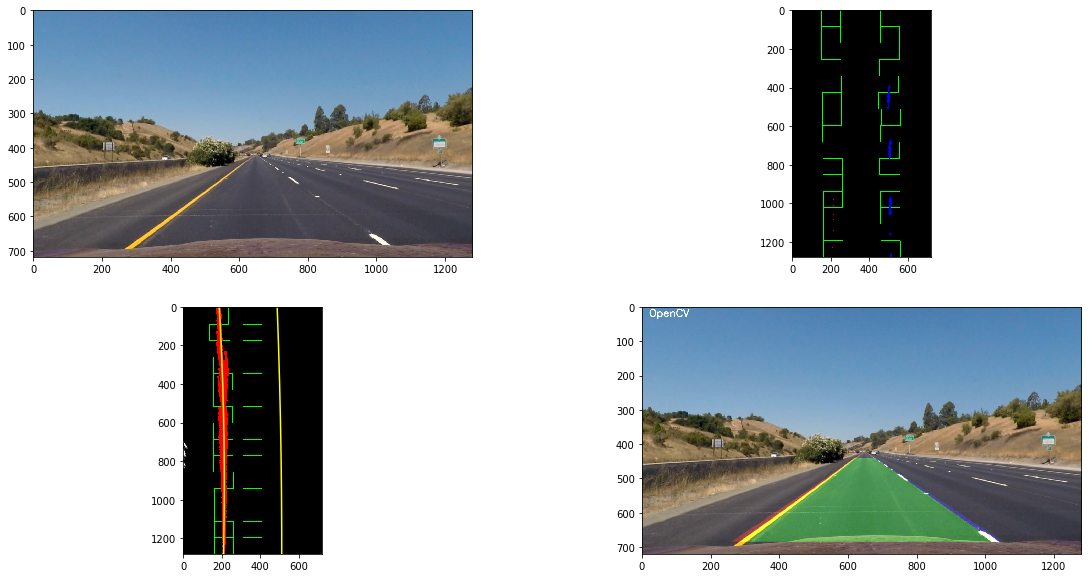

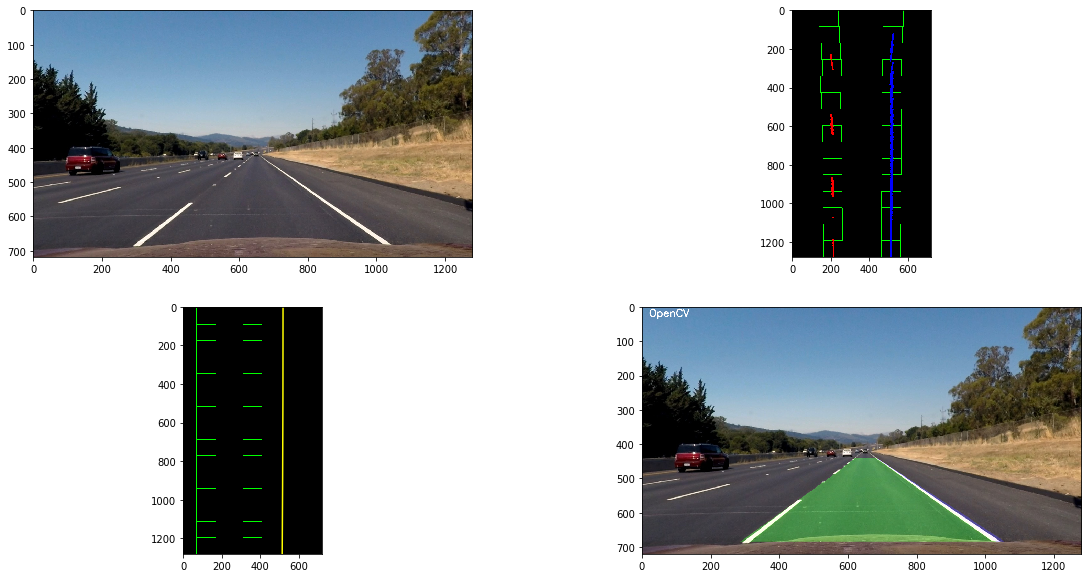

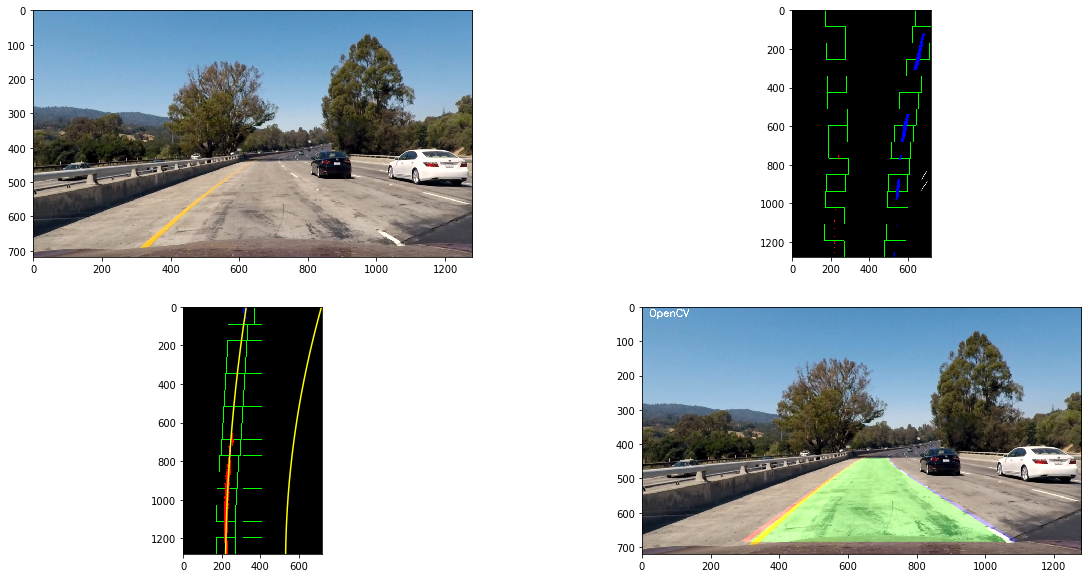

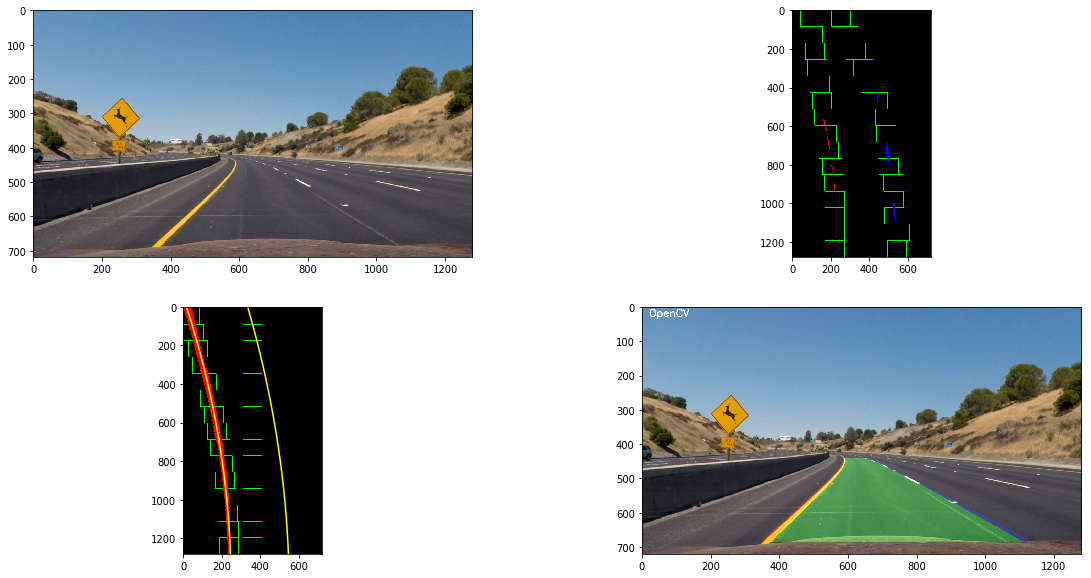

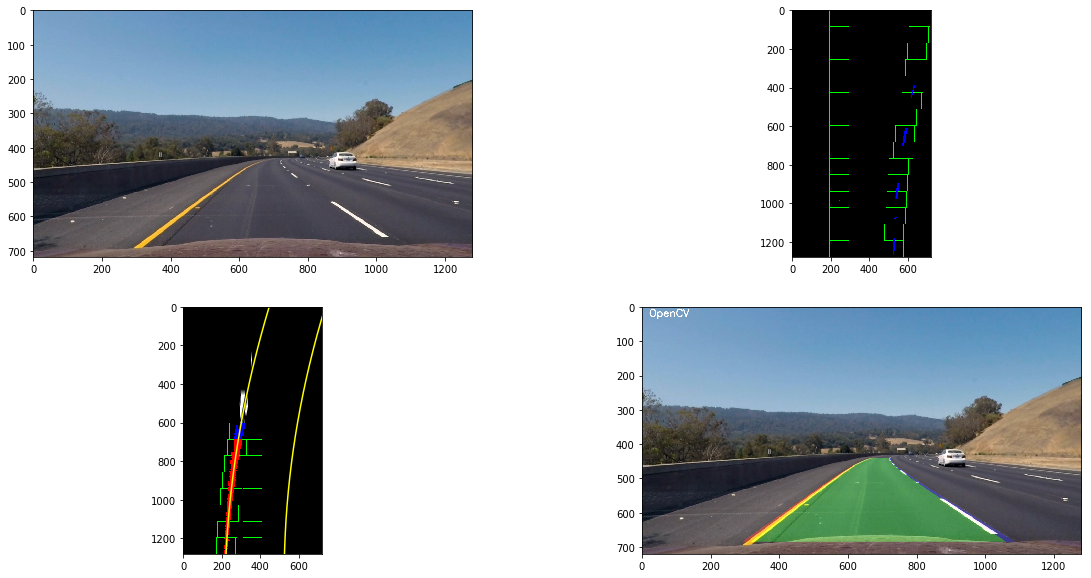

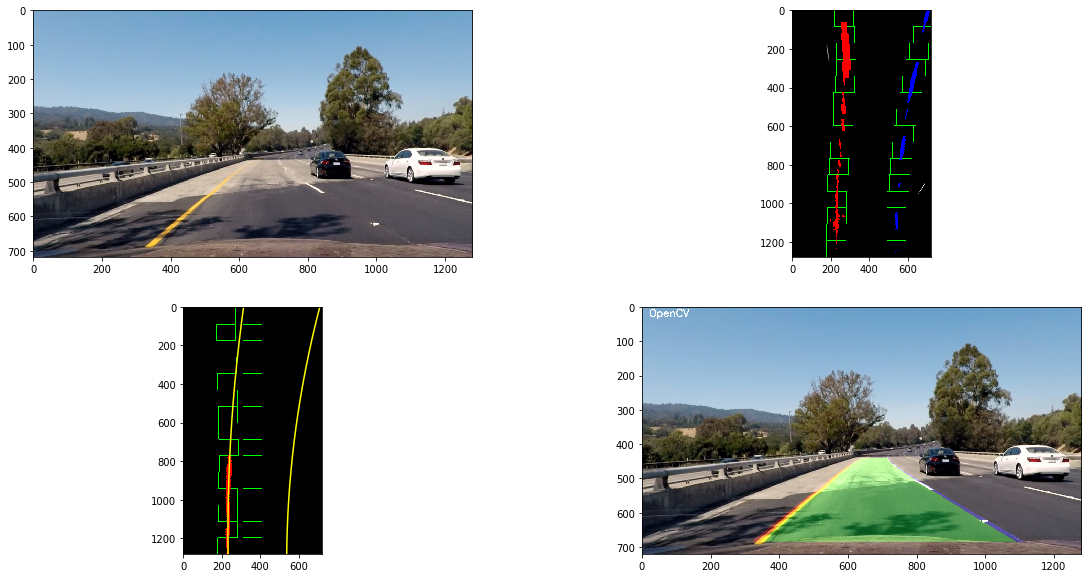

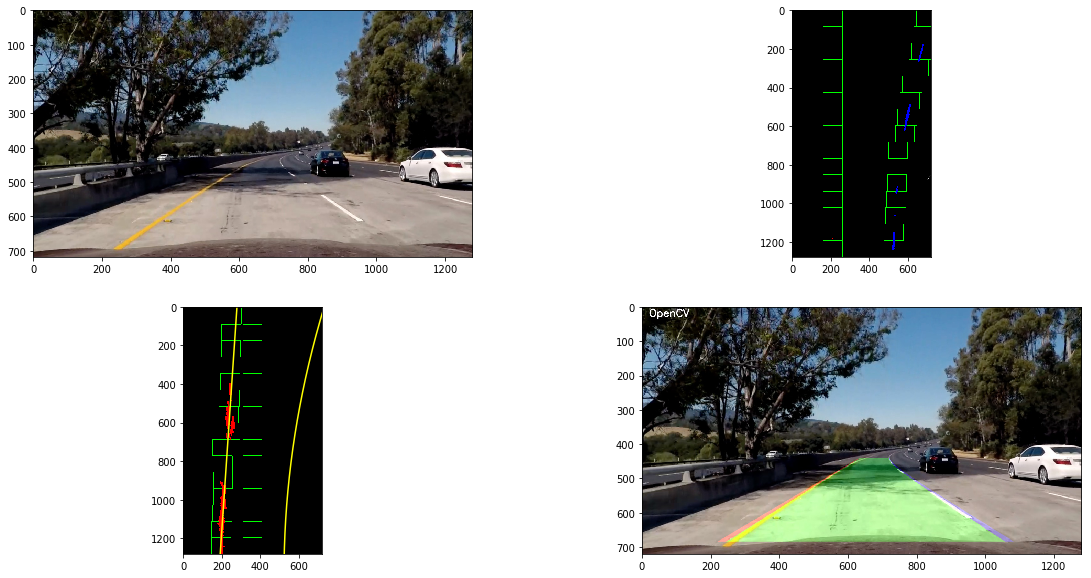

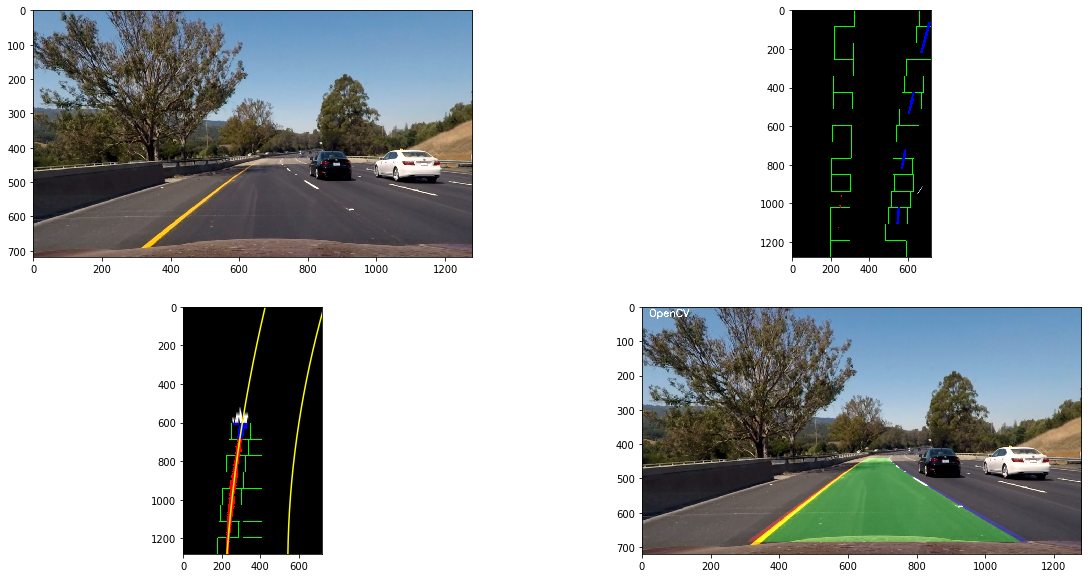

In [4]:

#fig = plt.figure(figsize = (20, 20))
for i, fimage in enumerate(glob.glob('test_images/*.jpg')):
    fig = plt.figure(figsize = (20, 10))
    distort = cv2.imread(fimage)
    img = undistort(distort)
    show_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    #plot original image
    fig.add_subplot(2, 2, 1)
    plt.imshow(show_img)
    
    h, w = img.shape[:2]
    ploty = np.linspace(0, w-1, w )
    red = img[:,:,2]
    
    sobelr = sobelx(red)
    threshw = thresh_white(img)
    threshs = thresh_hlS(img)
    threshy = thresh_yellow(img)
    threshg = thresh_green(img)

    combined = np.dstack((sobelr, threshs, threshy))
    combined_binary = cv2.bitwise_or(sobelr, threshw)
    combined_binary = cv2.bitwise_or(combined_binary, threshs)
    combined_binary = cv2.bitwise_or(combined_binary, threshy)
    combined_binary = cv2.bitwise_and(combined_binary, cv2.bitwise_not(threshg))

    mask = np.zeros_like(combined_binary)
    pts_roi = np.array([[[215, 690],[560, 390],[720, 390],[1100, 690]]], np.int32)
    cv2.fillPoly(mask, pts_roi, 255)
    
    (_, right_fit, debug1), dbase = find_lanes(threshw, mask, None, None)
    cv2.imwrite('./output_images/color_fit_lines.png', debug1)
    
    (left_fit, _, debug2), dbase = find_lanes(threshy, mask, None, None)
    print(left_fit, right_fit)
    
    sane, values = checkSanity(ploty, left_fit, right_fit, None, None)
    print(sane, values)
    
    marked_lanes = np.zeros_like(debug1)
    
    
    if left_fit is not None:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        cv2.polylines(marked_lanes, np.int_(pts_left), False, (255, 0, 0), 20, cv2.LINE_AA)
        left_curve = calcCurvature(ploty, left_fitx)
        print(fimage, 'Left', left_curve)
    
    if right_fit is not None:
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        cv2.polylines(marked_lanes, np.int_(pts_right), False, (0, 0, 255), 20, cv2.LINE_AA)
        right_curve = calcCurvature(ploty, right_fitx)
        print(fimage, 'Right', right_curve)
        
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(marked_lanes, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    retransformed = retransform(marked_lanes)
    # Combine the result with the original image
    result = cv2.addWeighted(show_img, 1, retransformed, 0.3, 0)
    cv2.putText(result,'OpenCV', (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    fig.add_subplot(2, 2, 2)
    plt.imshow(debug1)
    
    fig.add_subplot(2, 2, 3)
    plt.imshow(debug2)
    if left_fit is not None:
        plt.plot(left_fitx, ploty, color='yellow')
    if right_fit is not None:
        plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, h)
    plt.ylim(w, 0)
    
    fig.add_subplot(2, 2, 4)
    plt.imshow(result)
    

### State Class

In [5]:
class State():
    
    def __init__(self):
        self.frame = 0
        self.found = [False, False]
        self.last_left_fits = [None]
        self.last_right_fits = [None]
        self.lanePoly = None

last_lanes_limit = 5
debug = False

### Pipeline

In [6]:
#final Pipeline
def pipeline(img):
    state.frame += 1
    
    #Step 0 #RGB2BGR
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    #Step 1 Undistort
    uimg = undistort(img)
    
    #get Params
    h, w = uimg.shape[:2]
    ploty = np.linspace(0, w-1, w )
    
    #Step 2 Color and Gradients
    red = uimg[:,:,2]
    sobelr = sobelx(red)
    threshw = thresh_white(uimg)
    threshs = thresh_hlS(uimg)
    threshy = thresh_yellow(uimg)
    threshg = thresh_green(uimg)
    
    combined_binary = cv2.bitwise_or(sobelr, threshw)
    combined_binary = cv2.bitwise_or(combined_binary, threshs)
    combined_binary = cv2.bitwise_or(combined_binary, threshy)
    combined_binary = cv2.bitwise_and(combined_binary, cv2.bitwise_not(threshg)) #lane markings are never green
    
    if debug:
        print('Frame:', state.frame, 'Found:', state.found)
    old_left = None
    old_right = None
    for fit in state.last_left_fits:
        if fit is not None:
            old_left = fit
    for fit in state.last_right_fits:
        if fit is not None:
            old_right = fit
    
    #Step 3 ROI
    if state.lanePoly is not None:
        mask = cv2.dilate(state.lanePoly, np.ones((15,15), np.uint8), iterations = 1)
    else:
        pts_roi = np.array([[[215, 690],[560, 390],[720, 390],[1100, 690]]], np.int32)
        mask = np.zeros_like(combined_binary)
        cv2.fillPoly(mask, pts_roi, 255)
    
    #Step 4 and 5 Find lanes using sliding Window and Sanity Check
    (left_fit, right_fit, debug1), dbase = find_lanes(threshw, mask, old_left, old_right)
    sane, values = checkSanity(ploty, left_fit, right_fit, old_left, old_right)
    if debug:
        print('White:', sane)
    level = 0
    if not sane[0] or not sane[1]:
        level = 1
        if sane[0]:
            (_, right_fit, debug2), dbase = find_lanes(threshy, mask, left_fit, old_right)
        elif sane[1]:
            (left_fit, _, debug2), dbase = find_lanes(threshy, mask, old_left, right_fit)
        else:
            (left_fit, right_fit, debug2), dbase = find_lanes(threshy, mask, old_left, old_right)
        sane, values = checkSanity(ploty, left_fit, right_fit, old_left, old_right)
        if debug:
            print('Yellow:', sane)
    if not sane[0] or not sane[1]:
        level = 2
        if sane[0]:
            (_, right_fit, debug3), dbase = find_lanes(combined_binary, mask, left_fit, old_right)
        elif sane[1]:
            (left_fit, _, debug3), dbase = find_lanes(combined_binary, mask, old_left, right_fit)
        else:
            (left_fit, right_fit, debug3), dbase = find_lanes(combined_binary, mask, old_left, old_right)
        sane, values = checkSanity(ploty, left_fit, right_fit, old_left, old_right)
        if debug:
            print('Combined:', sane)
    if sane[0] != sane[1]:
        (left_fit, right_fit, debug3), dbase = find_lanes(combined_binary, mask, old_left, old_right)
        sane, values = checkSanity(ploty, left_fit, right_fit, old_left, old_right)
    
    if debug:    
        print(sane, values, dbase)

    if left_fit is None or not sane[0] and old_left is not None:
        left_fit = old_left
    if right_fit is None or not sane[1] and old_right is not None:
        right_fit = old_right
        
    #Step 6 Draw lines: use mean of last found 5 lanes
    marked_lanes = np.zeros((w, h, 3), np.uint8)
    lanePoly = np.zeros((w, h, 1), np.uint8)
    
    if left_fit is not None:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        old_left_fitx = [f[0]*ploty**2 + f[1]*ploty + f[2] for f in state.last_left_fits if f is not None]
        left_fitx = np.mean([left_fitx] + old_left_fitx, axis = 0)
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        cv2.polylines(marked_lanes, np.int_(pts_left), False, (255, 0, 0), 20, cv2.LINE_AA)
        if level == 0:
            cv2.polylines(debug1, np.int_(pts_left), False, (0, 255, 0), 20, cv2.LINE_AA)
        elif level == 1:
            cv2.polylines(debug2, np.int_(pts_left), False, (0, 255, 0), 20, cv2.LINE_AA)
        elif level == 2:
            cv2.polylines(debug3, np.int_(pts_left), False, (0, 255, 0), 20, cv2.LINE_AA)
    
    if right_fit is not None:
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        old_right_fitx = [f[0]*ploty**2 + f[1]*ploty + f[2] for f in state.last_right_fits if f is not None]
        right_fitx = np.mean([right_fitx] + old_right_fitx, axis = 0)
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        cv2.polylines(marked_lanes, np.int_(pts_right), False, (0, 0, 255), 20, cv2.LINE_AA)
        if level == 0:
            cv2.polylines(debug1, np.int_(pts_right), False, (0, 255, 0), 20, cv2.LINE_AA)
        elif level == 1:
            cv2.polylines(debug2, np.int_(pts_right), False, (0, 255, 0), 20, cv2.LINE_AA)
        elif level == 2:
            cv2.polylines(debug3, np.int_(pts_right), False, (0, 255, 0), 20, cv2.LINE_AA)
    
    if left_fit is not None and right_fit is not None:
        pts = np.hstack((pts_left, pts_right))
        cv2.fillPoly(marked_lanes, np.int_([pts]), (0,255, 0))
        cv2.fillPoly(lanePoly, np.int_([pts]), 255)

    retransformed = retransform(marked_lanes)
    # Combine the result with the original image
    result = cv2.addWeighted(uimg, 1, retransformed, 0.3, 0)

    #Step 7 Calculate curvature:
    curverad = 0
    if left_fit is not None:
        left_curverad = calcCurvature(ploty, left_fitx)
        leftx_base = left_fit[0]*w**2 + left_fit[1]*w + left_fit[2]
        curverad = left_curverad
    if right_fit is not None:
        right_curverad = calcCurvature(ploty, right_fitx)
        rightx_base = right_fit[0]*w**2 + right_fit[1]*w + right_fit[2]
        curverad = right_curverad
    if left_fit is not None and right_fit is not None:
        curverad = (left_curverad + right_curverad) / 2
        center = (rightx_base + leftx_base) / 2
        center_diff = (h/2) - center
        xm_per_pix = 3.7/330
        center_diff_m = center_diff * xm_per_pix
        cv2.putText(result,'Curve Radius: {:.2f}m'.format(curverad), (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),
                2, cv2.LINE_AA)
        cv2.putText(result,'Car is {:.2f}m right of lane center.'.format(center_diff_m), (10,60), cv2.FONT_HERSHEY_SIMPLEX,
                1, (255,255,255), 2, cv2.LINE_AA)
    
    #Step 8 Save parameters
    state.found = sane
    if sane[0]:
        state.last_left_fits.append(left_fit)
        if len(state.last_left_fits) > last_lanes_limit:
            state.last_left_fits = state.last_left_fits[1:]
    if sane[1]:
        state.last_right_fits.append(right_fit)
        if len(state.last_right_fits) > last_lanes_limit:
            state.last_right_fits = state.last_right_fits[1:]
    if sane[0] and sane[1]:
        state.lanePoly = retransform(lanePoly)
    else:
        state.lanePoly = None
    
    if debug:
        cv2.imwrite('test_images/debug/{}eimg.png'.format(state.frame), img)
        cv2.imwrite('test_images/debug/{}emask.png'.format(state.frame), cv2.bitwise_and(combined_binary, mask))
        cv2.imwrite('test_images/debug/{}edebug1.png'.format(state.frame), debug1)
        if level > 0:
            cv2.imwrite('test_images/debug/{}edebug2.png'.format(state.frame), debug2)
        if level > 1:
            cv2.imwrite('test_images/debug/{}edebug3.png'.format(state.frame), debug3)
        cv2.imwrite('test_images/debug/{}eresult.png'.format(state.frame), result)
    
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    return result
    

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
state = State()

output = 'output_images/project_video.mp4'

clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:13<00:00,  5.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

Wall time: 4min 14s


In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [10]:
state = State()

output2 = 'output_images/challenge_video.mp4'

clip2 = VideoFileClip("challenge_video.mp4")
white_clip = clip2.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output2, audio=False)

[MoviePy] >>>> Building video output_images/challenge_video.mp4
[MoviePy] Writing video output_images/challenge_video.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [02:08<00:00,  3.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/challenge_video.mp4 

Wall time: 2min 9s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output2))

In [12]:
state = State()

output3 = 'output_images/harder_challenge_video.mp4'

clip3 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip3.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output3, audio=False)

[MoviePy] >>>> Building video output_images/harder_challenge_video.mp4
[MoviePy] Writing video output_images/harder_challenge_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [03:45<00:00,  5.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/harder_challenge_video.mp4 

Wall time: 3min 46s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output3))